# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

In [2]:
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


## Разбейте данные на выборки

In [3]:
features = df.drop('is_ultra', axis=1)
target = df['is_ultra']

У нас нет спрятанной тестовой выборки, соответственно разбиваем выборку в соотношении 3:1:1.

In [4]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.4, random_state=12345)

In [5]:
print(f'Размер обучающей выборки: {features_train.shape}; {target_train.shape}')

Размер обучающей выборки: (1928, 4); (1928,)


Отделяем 60% выборки под обучающую, а далее оставшуюся 40-ка % выборку делим еще на 2 выборки.

In [6]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features, target, test_size=0.5, random_state=12345)

In [7]:
print(f'Размер валидационной выборки: {features_valid.shape}; {target_valid.shape}')
print(f'Размер тестовой выборки: {features_test.shape}; {target_test.shape}')

Размер валидационной выборки: (1607, 4); (1607,)
Размер тестовой выборки: (1607, 4); (1607,)


## Исследуйте модели

### **Модель "Дерево решений".**

Text(0.5, 1.0, 'Accuracy в зависимости от количества деревьев')

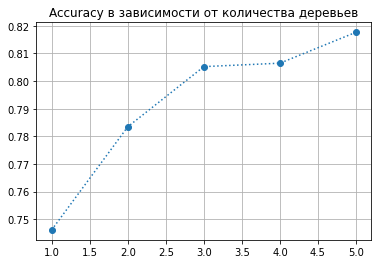

In [10]:
depth = []
accuracy = []
for col in range(1, 6):
    model_DT = DecisionTreeClassifier(random_state=12345, max_depth=col).fit(features_train, target_train)
    predictions_valid = model_DT.predict(features_valid)
    depth.append(col)
    accuracy.append(accuracy_score(target_valid, predictions_valid))
plt.plot(depth, accuracy, ':o') 
plt.grid()
plt.title('Accuracy в зависимости от количества деревьев')

Text(0.5, 1.0, 'Accuracy в зависимости от «минимального количество объектов в листе»')

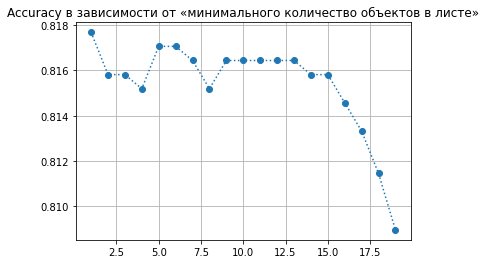

In [11]:
min_samples_leaf = []
accuracy = []
for col in range(1, 20):
    model_DT = DecisionTreeClassifier(random_state=12345, max_depth=5, min_samples_leaf=col).fit(features_train, target_train)
    predictions_valid = model_DT.predict(features_valid)
    min_samples_leaf.append(col)
    accuracy.append(accuracy_score(target_valid, predictions_valid))
plt.plot(min_samples_leaf, accuracy, ':o') 
plt.grid()
plt.title('Accuracy в зависимости от «минимального количество объектов в листе»')

*Из вышенаписанного можно сделать вывод, что самая лучшая модель дерева решений имеет глубину равную 5, а остальные параметры заполнены по умолчанию.*

In [12]:
best_model_DT = DecisionTreeClassifier(random_state=12345, max_depth=5).fit(features_train, target_train)

### **Модель "Случайный лес":**

(20.0, 40.0)

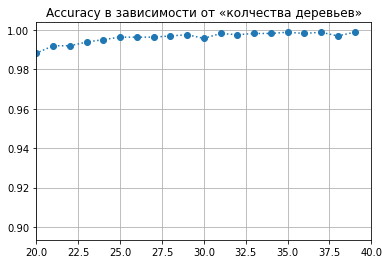

In [13]:
estimators = []
accuracy = []
for col in range(1, 40):
    model_RF = RandomForestClassifier(random_state=12345, n_estimators=col) 
    model_RF.fit(features_train, target_train) 
    estimators.append(col)
    accuracy.append(model_RF.score(features_valid, target_valid)) 
plt.plot(estimators, accuracy, ':o') 
plt.grid()
plt.title('Accuracy в зависимости от «количества деревьев»')
plt.xlim(20, 40)

(0.6, 9.4)

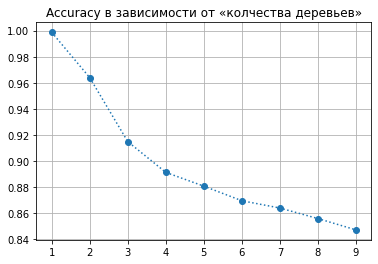

In [14]:
min_samples_leaf = []
accuracy = []
for col in range(1, 10):
    model_RF = RandomForestClassifier(random_state=12345, n_estimators=35, min_samples_leaf =col) 
    model_RF.fit(features_train, target_train) 
    min_samples_leaf.append(col)
    accuracy.append(model_RF.score(features_valid, target_valid)) 
plt.plot(min_samples_leaf, accuracy, ':o') 
plt.grid()
plt.title('Accuracy в зависимости от «колчества деревьев»')
plt.xlim()

In [16]:
clf = RandomForestClassifier()
parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }
grid = GridSearchCV(clf, parametrs)
grid.fit(features_train, target_train)
grid.best_params_

{'max_depth': 11,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 40}

In [19]:
model_RF1 = RandomForestClassifier(random_state=12345, n_estimators=40, min_samples_leaf =4, max_depth= 11) 
model_RF1.fit(features_train, target_train)
model_RF1.score(features_valid, target_valid)

0.8699439950217797

*Можно сказать, что в модели случайного леса наиболее результативной оказалась модель с 35-ю деревьями и параметрами по умолчанию.*

In [ ]:
best_model_RF = RandomForestClassifier(random_state=12345, n_estimators=35).fit(features_train, target_train)
best_model_RF.score(features_valid, target_valid)

### **Модель "Логистическая регрессия":**

In [ ]:
#iters = []
#accuracy = [ ]
#for col in range(1, 500):
    #model_LR = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=col).fit(features_train, target_train)  
    #iters.append(col)
    #accuracy.append(model_RF.score(features_valid, target_valid))
#plt.plot(iters, accuracy, ':o') 
#plt.grid()
#plt.title('Accuracy в зависимости от «колчества деревьев»')
#plt.xlim( )   

Одно и то же accuracy при итерациях от 40 до 1000.

In [ ]:
model_LR = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=40).fit(features_train, target_train)
print(f'Accuracy равно {model_LR.score(features_valid, target_valid)}')

In [ ]:
model_LR = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=2000).fit(features_train, target_train)
print(f'Accuracy равно {model_LR.score(features_valid, target_valid)}')

In [ ]:
best_model_LR = LogisticRegression(random_state=12345, solver='newton-cg', max_iter=200, penalty = 'l2').fit(features_train, target_train)
print(f'Accuracy равно {model_LR.score(features_valid, target_valid)}')

## Проверьте модель на тестовой выборке

In [ ]:
best_model_DT.score(features_test, target_test)

На тестовой выборке модель дерева решений показывает accuracy равным 0.7915.

In [ ]:
best_model_RF.score(features_test, target_test)

На тестовой выборке модель случайного леса показывает accuracy равным 0.827.

In [ ]:
best_model_LR.score(features_test, target_test)

На тестовой выборке модель логистической регрессии показывает accuracy равным 0.7573.

**Вывод: accuracy всех моделей больше 0.75, но предпочтение я бы отдал случайному лесу.**

## (бонус) Проверьте модели на адекватность

In [ ]:
len(df.query('is_ultra==0'))/ len(df['is_ultra'])

Если бы модель выдавала все нули, то accuracy была бы равна 0,69. У меня же на модели случайного леса она равна 0,82, что показывает, что модель адекватна.